In [1]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
import csv
import MeCab
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import re
import neologdn
import demoji
import emoji
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
import japanize_matplotlib

model_dir = '/Users/iomacbookair2/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
# model_dir = '/Users/labimac/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
model_word2vec = KeyedVectors.load_word2vec_format(model_dir, binary=True)
mecab = MeCab.Tagger(
    '-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')


In [2]:
path = "/Users/iomacbookair2/Documents/lab/DEIM2023/tweet_csv/nichiten/230115_nichiten.csv"
# path = "/Users/labimac/Documents/lab/DEIM2023/tweet_csv/221214_ann_wed.csv"

df = pd.read_csv((path))
df.sort_values(by = 'created_at', ascending = True, inplace = True)
df = df.reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.drop("author_id", axis=1)
df = df.drop("username", axis=1)
df = df.drop("tweet_id", axis=1)
df = df.drop("like_count", axis=1)
df = df.drop("retweet_count", axis=1)
df

,created_at,text
0,2023-01-15 10:00:00,#nichiten おはようございます📻
1,2023-01-15 10:00:01,安住さん、中澤さん、スタッフのみなさん、おはようございます。 そして、安住さんおかえりなさい...
2,2023-01-15 10:00:01,#nichiten
3,2023-01-15 10:00:01,#nichiten #安住紳一郎 さぁ！ ”nichiten安住”の2023年 始まりで...
4,2023-01-15 10:00:01,【局長待遇大復活祭】おはようございます。 #nichiten
...,...,...
3934,2023-01-15 11:59:10,エンディングは 「show me」 コロナに罹った安住さんが コロナをないがしろにする 政府...
3935,2023-01-15 11:59:13,安住さん🥸中澤さん👸 高橋洋子さん👸 今日も楽しい2時間でした！ 安住さん🥸、 お身体をお大...
3936,2023-01-15 11:59:33,中尾明慶さん、好きな俳優さん😆#nichiten
3937,2023-01-15 11:59:44,黒木華ちゃんの『凪のお暇』も『重版出来！』も良かったなぁ。 #nichiten


In [3]:
def preprocess(text):
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'#\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'＃\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'@\S+', '', text) # @を消す
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # URLをスペースに置き換え
    text = re.sub(r'https?://\S+', ' ', text) # URLをスペースに置き換え
    text = re.sub(r'!-/:-@[-`{-~]', r'', text) # 記号を消す
    text = re.sub(r'”', '', text)  # "を消す
    text = re.sub(r'"', '', text)  # "を消す
    text = re.sub(r"'", "", text) # 'を消す
    text = re.sub(r'[(-`)]', '', text)
    text = re.sub(
        "[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)  # 記号を消す
    text = re.sub(
        u'[■-♯【】「」『』;・ㅂﾟˊᗜ┏━┓┗┛ヾθ、│!-/`:-@-`{-~。|∀!〇╰`′‵ˋω.*ー…╭∇^_￣´｀•˘д↑艸╯→°д̀ᴗ˃˂⁽⁾φ└＼※彡𖥦←ꂹ]', '', text)  # 記号を消す
    text = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) # 小数点とカンマを消す
    text = re.sub(r'\d+', '0', text) # 数字を0に置き換え
    text = text.lower() # 英字を小文字に
    text = re.sub(r"[\u3000\t\r\n]", " ", text) # 空白文字をスペースに置き換え
    text = neologdn.normalize(text)
    return text


df['text'] = df['text'].apply(preprocess)
df


,created_at,text
0,2023-01-15 10:00:00,おはようございます
1,2023-01-15 10:00:01,安住さん中澤さんスタッフのみなさんおはようございますそして安住さんおかえりなさい
2,2023-01-15 10:00:01,
3,2023-01-15 10:00:01,さぁnichiten安住の年始まりですね今年も一年小毒吐きと苦笑いの日曜の朝楽しませていただ...
4,2023-01-15 10:00:01,局長待遇大復活祭おはようございます
...,...,...
3934,2023-01-15 11:59:10,エンディングはshow meコロナに罹った安住さんがコロナをないがしろにする政府へのアンチテ...
3935,2023-01-15 11:59:13,安住さん中澤さん高橋洋子さん今日も楽しい時間でした安住さんお身体をお大事に生活も大切に日も早...
3936,2023-01-15 11:59:33,中尾明慶さん好きな俳優さん
3937,2023-01-15 11:59:44,黒木華ちゃんの凪のお暇も重版出来も良かったなぁ


In [4]:
df.to_csv('220115_preprocessed.csv', index=False)

In [5]:
def words_list(sentence, model, mecab):
    if not sentence:
      pass
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
    return sentence_words


df["words"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else words_list(x, model_word2vec, mecab))
df


,created_at,text,words
0,2023-01-15 10:00:00,おはようございます,[]
1,2023-01-15 10:00:01,安住さん中澤さんスタッフのみなさんおはようございますそして安住さんおかえりなさい,"[安住, さん, 中澤, さん, スタッフ, みなさん, 安住, さん]"
2,2023-01-15 10:00:01,,0
3,2023-01-15 10:00:01,さぁnichiten安住の年始まりですね今年も一年小毒吐きと苦笑いの日曜の朝楽しませていただ...,"[nichiten, 安住, 年始, まり, 今年, 一年, 毒, 吐き, 苦笑い, 日曜,..."
4,2023-01-15 10:00:01,局長待遇大復活祭おはようございます,"[局長, 待遇, 大復活祭, おはよう, ござい]"
...,...,...,...
3934,2023-01-15 11:59:10,エンディングはshow meコロナに罹った安住さんがコロナをないがしろにする政府へのアンチテ...,"[エンディング, show, me, コロナ, 罹っ, 安住, さん, コロナ, ないがしろ..."
3935,2023-01-15 11:59:13,安住さん中澤さん高橋洋子さん今日も楽しい時間でした安住さんお身体をお大事に生活も大切に日も早...,"[安住, さん, 中澤, さん, 高橋洋子, さん, 今日, 楽しい, 時間, 安住, さん..."
3936,2023-01-15 11:59:33,中尾明慶さん好きな俳優さん,"[中尾明慶, さん, 好き, 俳優さん]"
3937,2023-01-15 11:59:44,黒木華ちゃんの凪のお暇も重版出来も良かったなぁ,"[黒木華, ちゃん, 凪のお暇, 重版, 出来, 良かっ]"


In [6]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_words = pd.DataFrame({
    "words": groups.apply(lambda x: [word for sublist in x["words"] if type(sublist) == list for word in sublist])
})
df_words = df_words.reset_index()
df_words


,created_at,words
0,2023-01-15 10:00:00,"[安住, さん, 中澤, さん, スタッフ, みなさん, 安住, さん, nichiten,..."
1,2023-01-15 10:01:00,"[安住紳一郎の日曜天国, はじ, 昨日, キャス, 声, 調子, 戻っ, て, よう, 安住..."
2,2023-01-15 10:02:00,"[安住, さんま, 声, 心配, し, 安住, さん, 帰り, なさい, オハヨウゴザイマス..."
3,2023-01-15 10:03:00,"[安住アナ, 帰り, なさい, 声, 本調子, 局長, 待遇, 殿, 声, 本調子, ない,..."
4,2023-01-15 10:04:00,"[かい, 笑, 鼻声, 喉, 大事, 白い巨塔, 唐沢寿明, 平成生まれ, 東野英治郎, モ..."
...,...,...
115,2023-01-15 11:55:00,"[うほほ, なつかしい, 曲, 冷凍, 和風, 野菜, カレ, 作れ, いい, ん, 最後,..."
116,2023-01-15 11:56:00,"[実況, 懐かしい, あな, たらしく, ない, 大事, 安住, さん, 中澤, さん, ス..."
117,2023-01-15 11:57:00,"[終わっ, 感, 楽しかっ, 楽しかっ, 素晴らしい, 放送, 拍手, 安住, さん, ご自..."
118,2023-01-15 11:58:00,"[安住, さん, 大事, 喉, 無理, する, 長引く, 無理, さら, シナモン, 期限,..."


In [7]:
df_words.to_csv('220115_words.csv', index=False)

In [8]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_words = pd.DataFrame({
    "words": groups.apply(lambda x: [word for sublist in x["words"] if type(sublist) == list for word in sublist])
})
df_words = df_words.reset_index()

In [9]:
def save_wordclowd(words, index):
    if len(words) == 0:
        plt.axis("off")
    else:
        wordcloud = WordCloud(background_color="white", width=600, height=400, min_font_size=15 ,
                              font_path='/Users/iomacbookair2/Library/Fonts/IBMPlexSansJP-Regular.otf',).generate(' '.join(words))
        plt.axis("off")
    plt.imshow(wordcloud)
    plt.savefig(f"nichiten220115_{index}.png")
    plt.clf()


df_words.apply(lambda x: save_wordclowd(x["words"], x.name), axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
115    None
116    None
117    None
118    None
119    None
Length: 120, dtype: object

<Figure size 640x480 with 0 Axes>

In [10]:
def word_to_vec(sentence, model, mecab):
    if not sentence:
        sentence_embedding = np.zeros(200, dtype=np.float32)
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                # if parts[1].startswith("名詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("動詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("形容詞"):
                #     sentence_words.append(features[6])
        # print(sentence_words)
        if all(re.match(r'.*[a-zA-Z].*', word) for word in sentence_words):
            sentence_embedding = np.zeros(200, dtype=np.float32)
        else:
            word_vectors = [model[word]
                            for word in sentence_words if word in model]
            if word_vectors:
                if len(word_vectors) == 0:
                    sentence_embedding = np.zeros(200, dtype=np.float32)
                else:
                    sentence_embedding = np.mean(word_vectors, axis=0)
            else:
                sentence_embedding = np.zeros(200, dtype=np.float32)
    return sentence_embedding

df["vector"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else word_to_vec(x, model_word2vec, mecab))
df = df.drop("text", axis=1)
df


,created_at,words,vector
0,2023-01-15 10:00:00,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2023-01-15 10:00:01,"[安住, さん, 中澤, さん, スタッフ, みなさん, 安住, さん]","[0.044606373, 0.7622781, 0.97223294, -0.447052..."
2,2023-01-15 10:00:01,0,0
3,2023-01-15 10:00:01,"[nichiten, 安住, 年始, まり, 今年, 一年, 毒, 吐き, 苦笑い, 日曜,...","[0.37017602, -0.010610922, 0.21203654, -0.5392..."
4,2023-01-15 10:00:01,"[局長, 待遇, 大復活祭, おはよう, ござい]","[0.14023694, -0.049483158, 0.26008004, -1.8142..."
...,...,...,...
3934,2023-01-15 11:59:10,"[エンディング, show, me, コロナ, 罹っ, 安住, さん, コロナ, ないがしろ...","[-0.4049973, 0.35919425, -0.06133514, -0.74042..."
3935,2023-01-15 11:59:13,"[安住, さん, 中澤, さん, 高橋洋子, さん, 今日, 楽しい, 時間, 安住, さん...","[-0.06923067, 0.30636162, 0.0058038915, -0.664..."
3936,2023-01-15 11:59:33,"[中尾明慶, さん, 好き, 俳優さん]","[-1.1426502, -0.85391325, 0.6253644, -0.173843..."
3937,2023-01-15 11:59:44,"[黒木華, ちゃん, 凪のお暇, 重版, 出来, 良かっ]","[0.27062902, -0.12854159, -0.9902789, -0.04731..."


In [11]:
df.to_csv('220115_vector.csv', index=False)

In [12]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_vectors = pd.DataFrame({
    "vectors": groups.apply(lambda x: x["vector"].tolist())
})
df_vectors = df_vectors.reset_index()
df_vectors


,created_at,vectors
0,2023-01-15 10:00:00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,2023-01-15 10:01:00,"[[-0.09780312, 0.58405256, 0.8148076, -0.10430..."
2,2023-01-15 10:02:00,"[[0.65810764, 0.38757867, -0.3383707, -1.13672..."
3,2023-01-15 10:03:00,"[[-0.035847377, 0.13401988, 0.42404863, -1.096..."
4,2023-01-15 10:04:00,"[[0.8833382, -0.018034652, 1.806968, 0.9884814..."
...,...,...
115,2023-01-15 11:55:00,"[[-0.8419942, 0.30366996, -0.4926432, 1.809439..."
116,2023-01-15 11:56:00,"[[0.09694148, -2.322626, 0.8472213, -0.3345706..."
117,2023-01-15 11:57:00,"[[1.1205893, 0.21609108, 0.20702606, 0.0677990..."
118,2023-01-15 11:58:00,"[[-0.27068785, 0.103343405, -0.23429912, -0.21..."


In [13]:
def calc_similarity(vector1, vector2):
  similarity = cosine_similarity(vector1, vector2)[0][0]
  return similarity


def calc_average_similarity(vectors, key):
    similarities = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if np.all(vectors[i] == 0) or np.all(vectors[j] == 0):
                continue
            else:
                similarity = calc_similarity(vectors[i].reshape(1, -1), vectors[j].reshape(1, -1))
            similarities.append(similarity)
    q = [0, 0.25, 0.5, 0.75, 1]
    outputs = {}
    for i in range(len(q)):
        outputs[f"q{i}"] = np.quantile(similarities, q[i])
    outputs["standard_deviation"] = np.std(similarities)
    outputs["mean"] = np.mean(similarities)
    if key == "q2":
        return outputs["q2"]
    elif key == "q1":
        return outputs["q1"]
    elif key == "q3":
        return outputs["q3"]
    elif key == "standard_deviation":
        return outputs["standard_deviation"]
    elif key == "mean":
        return outputs["mean"]


In [14]:
df_vectors["q1"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q1"))
df_vectors["q2"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q2"))
df_vectors["q3"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q3"))
df_vectors["mean"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "mean"))
df_vectors["stdev"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "standard_deviation"))
df_vectors = df_vectors.drop("vectors", axis=1)
df_vectors


,created_at,q1,q2,q3,mean,stdev
0,2023-01-15 10:00:00,0.074637,0.190152,0.327471,0.222338,0.215078
1,2023-01-15 10:01:00,0.127432,0.249704,0.428259,0.289311,0.227661
2,2023-01-15 10:02:00,0.143587,0.284657,0.439275,0.306867,0.214431
3,2023-01-15 10:03:00,0.168097,0.325663,0.486142,0.329306,0.215974
4,2023-01-15 10:04:00,0.105808,0.251342,0.405408,0.264148,0.202493
...,...,...,...,...,...,...
115,2023-01-15 11:55:00,0.208362,0.344498,0.480821,0.352996,0.198768
116,2023-01-15 11:56:00,0.259224,0.422038,0.587899,0.430081,0.223795
117,2023-01-15 11:57:00,0.383902,0.530814,0.697545,0.534212,0.188330
118,2023-01-15 11:58:00,0.452601,0.552139,0.645536,0.543677,0.146837


In [15]:
df_vectors.to_csv('220115_similarity.csv', index=False)


In [16]:
path_count = "/Users/iomacbookair2/Documents/lab/DEIM2023/word2vec/nichiten/220115_count.csv"
# path_count = "/Users/labimac/Documents/lab/DEIM2023/count/count_221214_ann_wed.csv"
df_count = pd.read_csv((path_count))
df_vectors["tweet"] = df_count["tweet"]
df_vectors['created_at'] = df_vectors['created_at'].astype(str)
start_time = df_vectors['created_at'].min()
start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: (
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - start_time).total_seconds() / 60)
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: round(x))
df_vectors


,created_at,q1,q2,q3,mean,stdev,tweet
0,0,0.074637,0.190152,0.327471,0.222338,0.215078,60
1,1,0.127432,0.249704,0.428259,0.289311,0.227661,94
2,2,0.143587,0.284657,0.439275,0.306867,0.214431,111
3,3,0.168097,0.325663,0.486142,0.329306,0.215974,105
4,4,0.105808,0.251342,0.405408,0.264148,0.202493,98
...,...,...,...,...,...,...,...
115,115,0.208362,0.344498,0.480821,0.352996,0.198768,56
116,116,0.259224,0.422038,0.587899,0.430081,0.223795,55
117,117,0.383902,0.530814,0.697545,0.534212,0.188330,25
118,118,0.452601,0.552139,0.645536,0.543677,0.146837,16


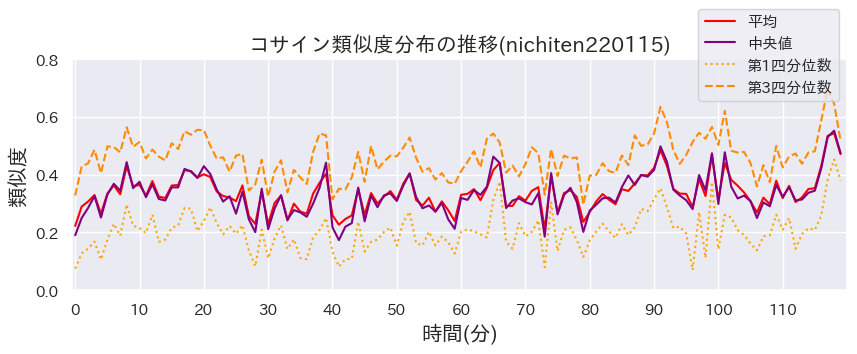

In [17]:
window_sizes = [1]
for window in window_sizes:
    df_vectors['q1'] = df_vectors['q1'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q2'] = df_vectors['q2'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q3'] = df_vectors['q3'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "コサイン類似度分布の推移(nichiten220115)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(-0.5, num_rows)
    ax.set_ylim(0, 0.8)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("類似度", fontsize=15)
    ax.plot(df_vectors["created_at"], df_vectors["mean"], color="red",
            label="平均")
    ax.plot(df_vectors["created_at"], df_vectors["q2"], color="purple",
            label="中央値")
    ax.plot(df_vectors["created_at"], df_vectors["q1"], color="orange", linestyle="dotted",
            label="第1四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["q3"], color="darkorange", linestyle="dashed",
            label="第3四分位数")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1.25))
    plt.savefig('quantile_{}.png'.format(window))


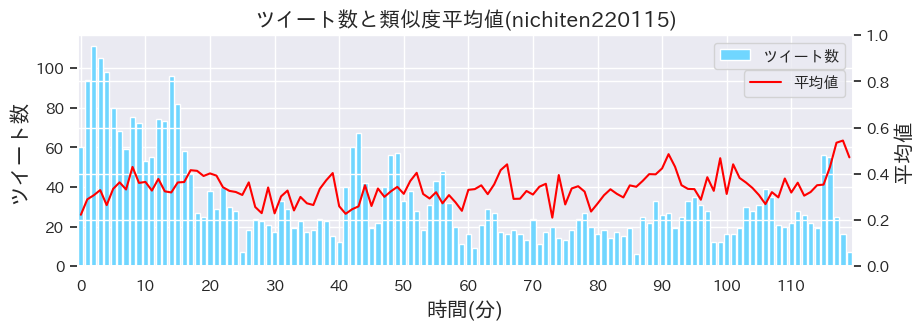

In [18]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "ツイート数と類似度平均値(nichiten220115)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(-0.5, num_rows - 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("平均値", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["mean"], color="red",
             label="平均値")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.88))
    plt.savefig('mean_{}.png'.format(window))


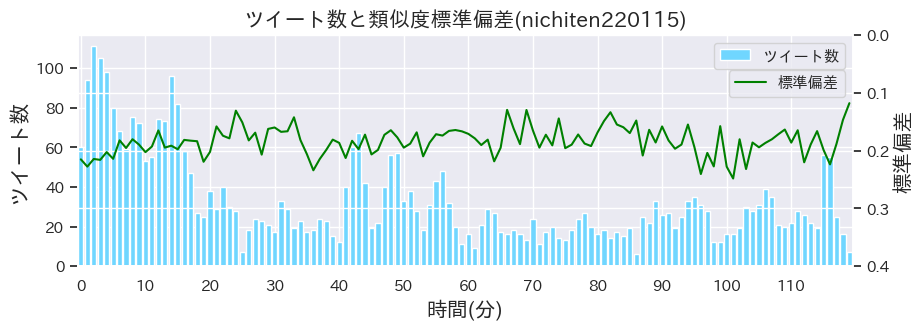

In [19]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['stdev'] = df_vectors['stdev'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "ツイート数と類似度標準偏差(nichiten220115)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(-0.5, num_rows - 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0.4, 0)
    ax2.set_ylabel("標準偏差", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["stdev"], color="green",
             label="標準偏差")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.88))
    plt.savefig('stdev_{}.png'.format(window))
